### Example with DataLinks and LinkLikelihood class
Testing a way to measure scores from co-occurences in the data.

In [1]:
# data locations
DATASET = "C:\\Users\\FlorianHuber\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_MS2LDA = DATASET + "\\lda\\code\\"
PATH_MGF_DATA = DATASET + "\\Data\\Crusemann_dataset\\Crusemann_only_Clutered_Data\\"
MIBIG_JSON_DIR = DATASET + "\\Data\\mibig\\mibig_json_1.4"

NODES_FILE = PATH_MGF_DATA + "clusterinfosummarygroup_attributes_withIDs\\0d51c5b6c73b489185a5503d319977ab..out"

MGF_FILE = PATH_MGF_DATA + "METABOLOMICS-SNETS-c36f90ba-download_clustered_spectra-main.mgf"
EDGES_FILE = PATH_MGF_DATA + 'networkedges_selfloop\\9a93d720f69143bb9f971db39b5d2ba2.pairsinfo'

ROOT_PATH = DATASET + "\\Data\mibig_select\\"
FOLDERS = ['NRPS','Others','PKSI','PKS-NRP_Hybrids','PKSother','RiPPs','Saccharides','Terpene']
ANTISMASH_DIR = DATASET +"\\Data\\Crusemann_dataset\\bgc_crusemann\\"

from nplinker_constants import nplinker_setup #,setup_paths_simon
nplinker_setup(LDA_PATH=PATH_MS2LDA)

# MIBIG_JSON_DIR,NODES_FILE,DEREP_ANNOTATIONS,MGF_FILE,EDGES_FILE,FOLDERS,ROOT_PATH,ANTISMASH_DIR = setup_paths_simon()
# nplinker_setup()


In [2]:
# import from NPlinker
from metabolomics import load_spectra
from metabolomics import load_metadata
from metabolomics import load_edges
from metabolomics import make_families
from genomics import loadBGC_from_cluster_files
from genomics import make_mibig_bgc_dict

from data_linking import DataLinks
from data_linking import LinkLikelihood
from data_linking import LinkFinder

# import general packages
import os
import glob

In [3]:
# load, initialize data
nplinker_setup(LDA_PATH=PATH_MS2LDA)

spectra = load_spectra(MGF_FILE)
load_edges(spectra, EDGES_FILE)
#families = make_families(spectra)
metadata = load_metadata(spectra, NODES_FILE)

input_files = []
ann_files = []
mibig_bgc_dict = make_mibig_bgc_dict(MIBIG_JSON_DIR)

for folder in FOLDERS:
    fam_file = os.path.join(ROOT_PATH, folder)
    cluster_file = glob.glob(fam_file + os.sep + folder + "_clustering*")
    annotation_files = glob.glob(fam_file + os.sep + "Network_*")
    input_files.append(cluster_file[0])
    ann_files.append(annotation_files[0])
gcf_list, bgc_list, strain_list = loadBGC_from_cluster_files(input_files, ann_files, antismash_dir=ANTISMASH_DIR, antismash_format = 'flat', mibig_bgc_dict=mibig_bgc_dict)

Loaded 5930 molecules
Found 1816 MiBIG json files


Now the data from the gene cluster families and spectra is loaded and initilized. 

The classes **DataLinks** and **LinkProbability** were written to test a possible alternative way to get correlation scores. The scoring is based on creating numpy co-occurence matrices which in principle should allow for very fast calculations.

In [4]:
# extract relevant linking mappings calculate co-occurences
data_links = DataLinks()
data_links.load_data(spectra, gcf_list, strain_list)
data_links.find_correlations(include_singletons=False)

Create mappings between spectra, gcfs, and strains.
Create co-occurence matrices: spectra<->strains + and gcfs<->strains.
Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf

Create correlation matrices: mol-families<->gcfs.
Calculating correlation matrices of type:  fam-gcf



In [5]:
# Calculate link probabilities, such as:
# P(gcf_x | spec_y) = probability to find gcf_x in a strain, given spec_y is present
# P(gcf_x | not spec_y) = probability to find gcf_x in a strain, given spec_y is NOT present 
likelihoods = LinkLikelihood()
likelihoods.calculate_likelihoods(data_links, type='spec-gcf')
likelihoods.calculate_likelihoods(data_links, type='fam-gcf')

Calculating likelihood matrices of type:  spec-gcf
Calculating likelihood matrices of type:  fam-gcf


### Select potential link candidates
#### Search for links between GCFs and spectra, and between GCFs and mol. families
Can now be done using the metcalf score or based on the likelihood ("likelihood score"). 

In [6]:
linkcandidates = LinkFinder()

linkcandidates.metcalf_scoring(data_links,
                        both=10, 
                        type1_not_gcf=-10, 
                        gcf_not_type1=0,
                        type='spec-gcf')

linkcandidates.metcalf_scoring(data_links,
                        both=10, 
                        type1_not_gcf=-10, 
                        gcf_not_type1=0,
                        type='fam-gcf')

array([[   54.,    54.,    54., ...,    23.,    54.,    31.],
       [-1002., -1002., -1002., ...,  -907., -1023.,  -983.],
       [ -815.,  -815.,  -815., ...,  -678.,  -815.,  -796.],
       ...,
       [  121.,   121.,   121., ...,   132.,   121.,   119.],
       [  132.,   132.,   132., ...,   122.,   132.,   151.],
       [  143.,   143.,   143., ...,   133.,   143.,   141.]])

Here is the second type of score(the one I had used before). Like the metcalf score it takes into account the directionality BGC-->compound-->spectrum, which suggests that the most relevant likelihoods are: 

P(gcf|type1) - If type1 is the result of only one particular gene cluster,
                            this value should be high (close or equal to 1)

P(type1|not gcf) - Following the same logic, this value should be very 
                                small or 0 ("no gene cluster, no compound") P(gcf_x | spec_y).
                                
This is then weighted by the number of strains this co-occurence was found in.

In [7]:
linkcandidates.likelihood_scoring(data_links, likelihoods, 
                        alpha_weighing=0.5,
                        type='spec-gcf')

linkcandidates.likelihood_scoring(data_links, likelihoods, 
                        alpha_weighing=0.5,
                        type='fam-gcf')

array([[0.03687055, 0.03687055, 0.03687055, ..., 0.        , 0.03687055,
        0.        ],
       [0.0009864 , 0.0009864 , 0.0009864 , ..., 0.01334531, 0.        ,
        0.00312973],
       [0.00170039, 0.00170039, 0.00170039, ..., 0.03450035, 0.00170039,
        0.0054402 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.19525546, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.39346934],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

Using those scores it is then possible to select suitable, promising candidates for potential links between spectra and GCFs, or mol.families and GCFs.

In [8]:
link_candidates_spec = linkcandidates.select_link_candidates(data_links, likelihoods,
                               P_cutoff=0.9, 
                               main_score='likescore',
                               score_cutoff=0.7, 
                               type='spec-gcf')

link_candidates_fam = linkcandidates.select_link_candidates(data_links, likelihoods,
                               P_cutoff=0.8, 
                               main_score='likescore',
                               score_cutoff=0, 
                               type='fam-gcf')

1096  candidates selected with  P(gcf|spec)  >=  0.9  and a link score >=  0.7 .
2319  candidates selected with  P(gcf|fam)  >=  0.8  and a link score >=  0 .


What becomes apparent is that the score I used and metcalf are indeed very similar in the sense that they nearly sort candidates the same way. The score I use here ("likescore"or "likelihood score") might have the advantage that it is normalized to (0,1). 

### Probability of finding the same link simply by chance.
I now added further calculations to derive different probabilities of finding the same link (and same number of co-occurences) simply by chance.

##### "HG prob"
The probability to find the observed number of co-occurences based on the hypergeometric distribution.
##### "link prob"
The probability to find the observed number of co-occurences based on my approximated calculation (pdf I sent around).
##### "link prob specific"
The probability to find the specific observed co-occurences based on my approximated calculation (pdf I sent around).

In [9]:
# Show table of potential gcf<-> spectrum link candidates
link_candidates_spec.nlargest(10, 'likelihood score')

,spectrum_id,GCF id,P(gcf|spec),P(spec|gcf),P(gcf|not spec),P(spec|not gcf),co-occur in # strains,metcalf score,likelihood score,HG prob,link prob,link prob specific,BGC class
328,1777,1511,1.0,0.176471,0.202899,0.0,6,170,0.950213,0.000121,0.000017,1.012497e-09,Saccharides
465,2204,1511,1.0,0.176471,0.202899,0.0,6,170,0.950213,0.000121,0.000017,5.484087e-10,Saccharides
471,2369,829,1.0,0.130435,0.289855,0.0,6,158,0.950213,0.000841,0.000093,3.918778e-13,Others
1026,5488,251,1.0,0.139535,0.268116,0.0,6,161,0.950213,0.000547,0.000041,2.858327e-12,Others
1027,5488,342,1.0,0.136364,0.275362,0.0,6,160,0.950213,0.000633,0.000050,2.858327e-12,Others
1028,5488,384,1.0,0.125000,0.304348,0.0,6,156,0.950213,0.001101,0.000072,2.858327e-12,Others
1029,5488,422,1.0,0.111111,0.347826,0.0,6,150,0.950213,0.002318,0.000148,2.858327e-12,Others
1030,5488,425,1.0,0.157895,0.231884,0.0,6,166,0.950213,0.000248,0.000018,2.858327e-12,Others
1031,5488,426,1.0,0.122449,0.311594,0.0,6,155,0.950213,0.001255,0.000100,2.858327e-12,Others
1032,5488,429,1.0,0.162162,0.224638,0.0,6,167,0.950213,0.000209,0.000013,2.858327e-12,Others


In [10]:
# Show table of potential gcf<-> famliy link candidates
link_candidates_fam.nlargest(10, 'likelihood score')

,family_id,GCF id,P(gcf|fam),P(fam|gcf),P(gcf|not fam),P(fam|not gcf),co-occur in # strains,metcalf score,likelihood score,HG prob,link prob,link prob specific,BGC class
1594,282,499,0.9,0.180000,0.305970,0.010638,9,173,0.880534,0.000307,0.000006,1.803000e-14,Others
84,27,426,1.0,0.081633,0.321429,0.000000,4,135,0.864665,0.012334,0.002304,2.491679e-08,Others
165,43,556,1.0,0.117647,0.214286,0.000000,4,150,0.864665,0.002700,0.000838,3.270074e-07,Others
166,43,591,1.0,0.133333,0.185714,0.000000,4,154,0.864665,0.001595,0.000368,3.270074e-07,Others
167,43,815,1.0,0.133333,0.185714,0.000000,4,154,0.864665,0.001595,0.000242,3.270074e-07,Others
168,43,829,1.0,0.086957,0.300000,0.000000,4,138,0.864665,0.009499,0.002212,3.270074e-07,Others
169,43,970,1.0,0.080000,0.328571,0.000000,4,134,0.864665,0.013406,0.002993,3.270074e-07,Others
170,43,1489,1.0,0.095238,0.271429,0.000000,4,142,0.864665,0.006516,0.001298,3.270074e-07,Saccharides
280,68,824,1.0,0.166667,0.142857,0.000000,4,160,0.864665,0.000619,0.000445,1.522686e-07,Others
281,68,1558,1.0,0.125000,0.200000,0.000000,4,152,0.864665,0.002093,0.000633,1.522686e-07,Terpene


In [11]:
# Show most likely *link prob* links in the candidate links (= NOT very significant)
link_candidates_fam.nlargest(10, 'link prob')

,family_id,GCF id,P(gcf|fam),P(fam|gcf),P(gcf|not fam),P(fam|not gcf),co-occur in # strains,metcalf score,likelihood score,HG prob,link prob,link prob specific,BGC class
51,16,970,1.0,0.020000,0.342657,0.0,1,104,0.393469,0.347222,0.239459,0.012183,Others
384,150,970,1.0,0.020000,0.342657,0.0,1,104,0.393469,0.347222,0.239459,0.012183,Others
685,173,970,1.0,0.020000,0.342657,0.0,1,104,0.393469,0.347222,0.239459,0.012183,Others
1496,263,970,1.0,0.020000,0.342657,0.0,1,104,0.393469,0.347222,0.239459,0.003125,Others
2135,417,970,1.0,0.020000,0.342657,0.0,1,104,0.393469,0.347222,0.239459,0.008623,Others
20,16,422,1.0,0.018519,0.370629,0.0,1,100,0.393469,0.375000,0.238707,0.012183,Others
353,150,422,1.0,0.018519,0.370629,0.0,1,100,0.393469,0.375000,0.238707,0.012183,Others
654,173,422,1.0,0.018519,0.370629,0.0,1,100,0.393469,0.375000,0.238707,0.012183,Others
1466,263,422,1.0,0.018519,0.370629,0.0,1,100,0.393469,0.375000,0.238707,0.003125,Others
2085,393,422,1.0,0.018519,0.370629,0.0,1,100,0.393469,0.375000,0.238707,0.010403,Others


... from here on nothing updated ...


### Derive probability distributions
Here a quick start... still playing around...


In [13]:
import data_linking_functions as functions

In [14]:
num_strains = 140
Nx = 20 # in how many strains do we find GCF_x
Ny = 10 # in how many strains do we find spectrum_x
nys = 20 # how many of spectra with Ny = 15 exist in the data

p_distribution = functions.hit_prob_dist(num_strains, Nx, Ny, nys)

Text(0,0.5,'probability')

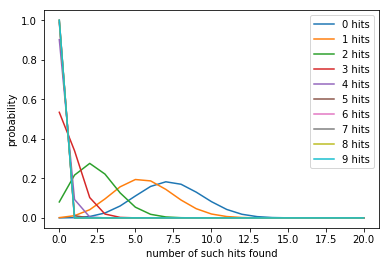

In [15]:
from matplotlib import pyplot as plt
for i, p_single in enumerate(p_distribution):
    plt.plot(p_single, label=str(i)+" hits")
plt.legend()
plt.xlabel("number of such hits found")   
plt.ylabel("probability")

## Metcalf score with neither:
Still seems problematic to me. For the Crusemann dataset most GCFs and spectra only occur in 1 or 2 strains. Given that we have about 140 strains, they would still score around +100 to +130 quite often.

In [16]:
from data_linking import RandomisedDataLinks

In [17]:
ms = linkcandidates.metcalf_scoring(data_links,
                        both=10, 
                        type1_not_gcf=-10, 
                        gcf_not_type1=0,
                        not_type1_not_gcf=0,
                        type='spec-gcf')

print(linkcandidates.metcalf_spec_gcf.shape)

ls = linkcandidates.likescores_spec_gcf
print(ls.shape)

(3125, 246)
(3125, 246)


Moving on to do some tests with the 
### RandomisedDataLinks...
To see how reproducible the method is I ran RamdomisedDatLinks 50 times and compared the results:

In [18]:
test_runs = 100

test_max_rms = np.zeros((ls.shape[0], test_runs))
test_max_rls = np.zeros((ls.shape[0], test_runs))
for i in range(test_runs):
    rdata_links = RandomisedDataLinks.from_datalinks(data_links)
    rdata_links.find_correlations(include_singletons=False)
    rms = linkcandidates.metcalf_scoring(rdata_links, not_type1_not_gcf=0, type='spec-gcf')
    
    rls = linkcandidates.likelihood_scoring(rdata_links, likelihoods, 
                        alpha_weighing=0.5,
                        type='spec-gcf')
    
    test_max_rms[:,i] = np.max(rms, axis=1) 
    test_max_rls[:,i] = np.max(rls, axis=1)

Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf

Create correlation matrices: mol-families<->gcfs.
Calculating correlation matrices of type:  fam-gcf

Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf

Create correlation matrices: mol-families<->gcfs.
Calculating correlation matrices of type:  fam-gcf

Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf

Create correlation matrices: mol-families<->gcfs.
Calculating correlation matrices of type:  fam-gcf

Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf

Create correlation matrices: mol-families<->gcfs.
Calculating correlation matrices of type:  fam-gcf

Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf

Create correlation matrices: mol-families<->gcfs.
Calculating correlation matrices of type:  fam-gcf



Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf

Create correlation matrices: mol-families<->gcfs.
Calculating correlation matrices of type:  fam-gcf

Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf

Create correlation matrices: mol-families<->gcfs.
Calculating correlation matrices of type:  fam-gcf

Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf

Create correlation matrices: mol-families<->gcfs.
Calculating correlation matrices of type:  fam-gcf

Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf

Create correlation matrices: mol-families<->gcfs.
Calculating correlation matrices of type:  fam-gcf

Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf

Create correlation matrices: mol-families<->gcfs.
Calculating correlation matrices of type:  fam-gcf



Calculating correlation matrices of type:  fam-gcf

Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf

Create correlation matrices: mol-families<->gcfs.
Calculating correlation matrices of type:  fam-gcf

Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf

Create correlation matrices: mol-families<->gcfs.
Calculating correlation matrices of type:  fam-gcf

Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf

Create correlation matrices: mol-families<->gcfs.
Calculating correlation matrices of type:  fam-gcf

Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf

Create correlation matrices: mol-families<->gcfs.
Calculating correlation matrices of type:  fam-gcf

Create correlation matrices: spectra<->gcfs.
Calculating correlation matrices of type:  spec-gcf

Create correlation matrices: mol-families<->gcfs.


In [19]:
import pandas as pd
rms_summary = np.zeros((ls.shape[0], 4))
rms_summary[:,0] = np.mean(test_max_rms, axis=1)
rms_summary[:,1] = np.std(test_max_rms, axis=1)
rms_summary[:,2] = np.min(test_max_rms, axis=1)
rms_summary[:,3] = np.max(test_max_rms, axis=1)
rms_summary = pd.DataFrame(rms_summary, columns = ['Mean','STD','Min','Max'])

rls_summary = np.zeros((ls.shape[0], 4))
rls_summary[:,0] = np.mean(test_max_rls, axis=1)
rls_summary[:,1] = np.std(test_max_rls, axis=1)
rls_summary[:,2] = np.min(test_max_rls, axis=1)
rls_summary[:,3] = np.max(test_max_rls, axis=1)
rls_summary = pd.DataFrame(rls_summary, columns = ['Mean','STD','Min','Max'])

In [20]:
rms_summary.head(10)  # Metcalf score (neither =0)

,Mean,STD,Min,Max
0,4.5,5.545268,-20.0,10.0
1,3.1,4.836321,-10.0,10.0
2,3.5,4.974937,0.0,20.0
3,2.8,5.114685,-10.0,10.0
4,3.9,4.877499,0.0,10.0
5,3.2,5.075431,-10.0,20.0
6,3.4,4.737088,0.0,10.0
7,3.7,5.413871,-10.0,10.0
8,2.9,4.958831,-10.0,10.0
9,3.7,4.828043,0.0,10.0


In [21]:
rls_summary.head(10)  # Likelihood score

,Mean,STD,Min,Max
0,0.039347,0.118041,0.0,0.393469
1,0.035412,0.112604,0.0,0.393469
2,0.000000,0.000000,0.0,0.000000
3,0.070824,0.151166,0.0,0.393469
4,0.000000,0.000000,0.0,0.000000
5,0.000000,0.000000,0.0,0.000000
6,0.000000,0.000000,0.0,0.000000
7,0.000000,0.000000,0.0,0.000000
8,0.000000,0.000000,0.0,0.000000
9,0.000000,0.000000,0.0,0.000000


### Issues with significancy measure
It appears like the max_rand and min_rand within the get_sig_links function are not a good-enough measure to define if a potential link is really significant. 
In the end it fluctuated a lot and will give different results every time we run it.

My feeling is, that we can not assign a significance value per GCF or per spectra (at least not this way).
What we can get is a feeling for how likely it is to get certain likelihood or metcalf scores simply by chance!

Unfortunately, no matter how high the score, it seems that chances remain fairly high that it will only  be a false positive. 

In [26]:
# Counting scores in bins
cum_rls = []
cum_ls = []
for i in range(100):
    cum_rls.append(np.sum((rls > i/100)))
    cum_ls.append(np.sum((ls > i/100)))

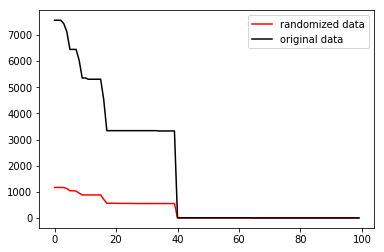

In [27]:
from matplotlib import pyplot as plt
plt.plot(cum_rls, 'r', label='randomized data')  
plt.plot(cum_ls, 'black', label='original data')    
plt.legend()  

In [21]:
# same for metcalf scores (here only positive ones)
cum_rms = []
cum_ms = []
for i in range(100):
    cum_rms.append(np.sum(rms > i))
    cum_ms.append(np.sum(ms > i))
    

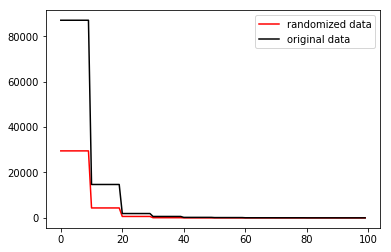

In [22]:
plt.plot(cum_rms, 'r', label='randomized data') 
plt.plot(cum_ms, 'black', label='original data')  
plt.legend()  

### Bit weird
That both cummulative distributions show the same steps might still be OK and an artifact of the scores used. But that we also see a fairly constant ratio sure looks a bit weird. I would have expected (or hoped), that we would get much less hits with high scores for the randomized data. But in fact in all cases it appears af if we have to assume a false-positive rate of about 0.2 to 0.3.

#### Export to cytoscape
There is now an added function to create network files that can be imported to Cytoscape.

In [11]:
# This will create a network from spectra <-> GCF links (including molecular family member links)
# Output is a graphml file
linkcandidates.create_cytoscape_files(data_links, 
                               'test_network.graphml', 
                               link_type='spec-gcf',
                               score_type='likescore')

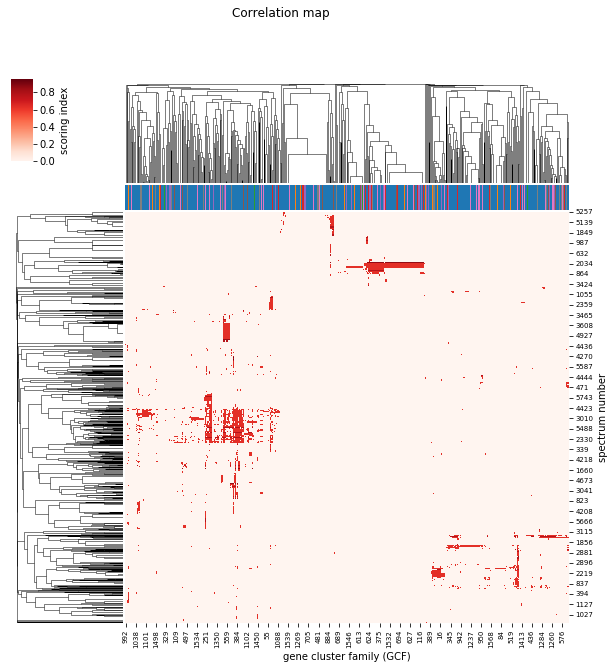

In [11]:
# do some test plotting to inspect the kind of results we get from there...
M_links = linkcandidates.plot_candidates(P_cutoff=0.95, 
                        score_type='likescore', 
                        score_cutoff=0.6, 
                        type='spec-gcf')

#### Show link candidates between GCFs and molecular families
Again done based on "likelihood score", but using metcalf scores gives nearly identical results here.

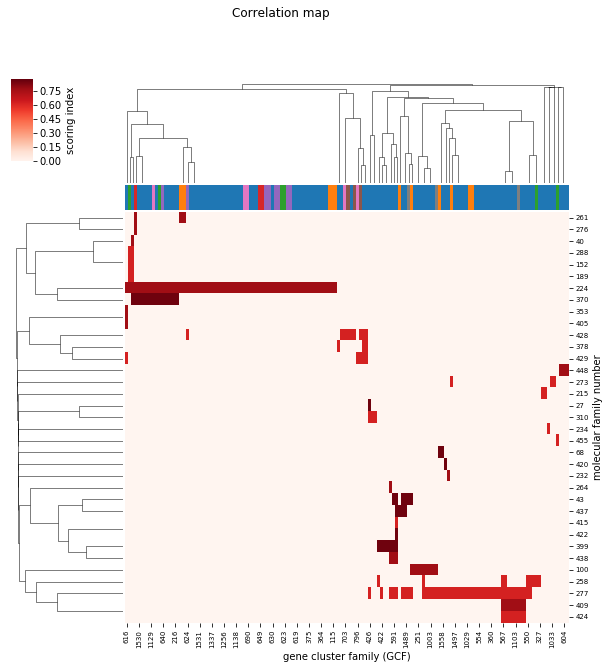

In [12]:
# do some test plotting to inspect the kind of results we get from there...
M_links = linkcandidates.plot_candidates(P_cutoff=0.9, 
                        score_type='likescore', 
                        score_cutoff=0.5, 
                        type='fam-gcf')